# Import appropriate functions

In [1]:
import os
import pandas as pd
import confidenceinterval


In [2]:
from scipy.stats import bootstrap
import numpy as np
from typing import List, Callable, Optional, Tuple

bootstrap_methods = [
    'bootstrap_bca',
    'bootstrap_percentile',
    'bootstrap_basic']


class BootstrapParams:
    n_resamples: int
    random_state: Optional[np.random.RandomState]


def bootstrap_ci(y_true: List[int],
                 y_pred: List[int],
                 metric: Callable,
                 confidence_level: float = 0.95,
                 n_resamples: int = 9999,
                 method: str = 'bootstrap_bca',
                 random_state: Optional[np.random.RandomState] = None) -> Tuple[float, Tuple[float, float]]:

    def statistic(*indices):
        indices = np.array(indices)[0, :]
        return metric(np.array(y_true)[indices], np.array(y_pred)[indices])

    assert method in bootstrap_methods, f'Bootstrap ci method {method} not in {bootstrap_methods}'

    indices = (np.arange(len(y_true)), )
    bootstrap_res = bootstrap(indices,
                              statistic=statistic,
                              n_resamples=n_resamples,
                              confidence_level=confidence_level,
                              method=method.split('bootstrap_')[1],
                              random_state=random_state)
    result = metric(y_true, y_pred)
    ci = bootstrap_res.confidence_interval.low, bootstrap_res.confidence_interval.high
    return result, ci

In [3]:
"""

This code is based on the fast delong method,
taken from this stack overflow thread:
https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

The original is from:
https://github.com/yandexdataschool/roc_comparison
"""

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/


def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float32)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float32)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float32)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float32)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(
            predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(
            predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed,
                       label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float32)
    ty = np.empty([k, n], dtype=np.float32)
    tz = np.empty([k, m + n], dtype=np.float32)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(
            positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(
            negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(
            predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(
        sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m] * (tz[:, :m] - tx)
            ).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float32)
    ty = np.empty([k, n], dtype=np.float32)
    tz = np.empty([k, m + n], dtype=np.float32)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(
        predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(
        aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

In [4]:
import numpy as np
from typing import Callable, List, Tuple
import sklearn.metrics
from scipy.stats import norm



def roc_auc_score_bootstrap(y_true: List,
                            y_pred: List,
                            confidence_level: float = 0.95,
                            method: str = 'bootstrap_bca',
                            n_resamples: int = 9999,
                            random_state: Callable = None) -> Tuple[float, float]:
    return bootstrap_ci(y_true=y_true,
                        y_pred=y_pred,
                        metric=sklearn.metrics.roc_auc_score,
                        confidence_level=confidence_level,
                        n_resamples=n_resamples,
                        method=method,
                        random_state=random_state)


def roc_auc_score(y_true: List,
                  y_pred: List,
                  confidence_level: float = 0.95,
                  method: str = 'delong',
                  *args, **kwargs) -> Tuple[float, float]:
    assert method in [
        'delong'] + bootstrap_methods, f"Method {method} not in {['delong'] + bootstrap_methods}"

    if method == 'delong':
        auc, variance = delong_roc_variance(np.array(y_true), np.array(y_pred))
        alpha = 1 - confidence_level
        z = norm.ppf(1 - alpha / 2)
        ci = auc - z * np.sqrt(variance), auc + z * np.sqrt(variance)
        return auc, ci
    elif method in bootstrap_methods:
        return roc_auc_score_bootstrap(
            y_true, y_pred, confidence_level, method, *args, **kwargs)

In [5]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

def plot_roc_95(y_true, y_probas, title='ROC Curves',
                   plot_micro=True, plot_macro=True, names=None, classes_to_plot=None,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium"):
    """Generates the ROC curves from labels and predicted scores/probabilities

    Args:
        y_true (array-like, shape (n_samples)):
            Ground truth (correct) target values.

        y_probas (array-like, shape (n_samples, n_classes)):
            Prediction probabilities for each class returned by a classifier.

        title (string, optional): Title of the generated plot. Defaults to
            "ROC Curves".

        plot_micro (boolean, optional): Plot the micro average ROC curve.
            Defaults to ``True``.

        plot_macro (boolean, optional): Plot the macro average ROC curve.
            Defaults to ``True``.

        classes_to_plot (list-like, optional): Classes for which the ROC
            curve should be plotted. e.g. [0, 'cold']. If given class does not exist,
            it will be ignored. If ``None``, all classes will be plotted. Defaults to
            ``None``

        ax (:class:`matplotlib.axes.Axes`, optional): The axes upon which to
            plot the curve. If None, the plot is drawn on a new set of axes.

        figsize (2-tuple, optional): Tuple denoting figure size of the plot
            e.g. (6, 6). Defaults to ``None``.

        cmap (string or :class:`matplotlib.colors.Colormap` instance, optional):
            Colormap used for plotting the projection. View Matplotlib Colormap
            documentation for available options.
            https://matplotlib.org/users/colormaps.html

        title_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "large".

        text_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "medium".

    Returns:
        ax (:class:`matplotlib.axes.Axes`): The axes on which the plot was
            drawn.
    """

    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas

    if names is None:
        names = classes

    if classes_to_plot is None:
        classes_to_plot = classes

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    fpr_dict = dict()
    tpr_dict = dict()

    indices_to_plot = np.in1d(classes, classes_to_plot)
    for i, to_plot in enumerate(indices_to_plot):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true, probas[:, i],
                                                pos_label=classes[i])
        
    if plot_macro:
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr_dict[x] for x in range(len(classes))]))
        print(all_fpr, 'all false positive rates')

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])

        # Finally average it and compute AUC
        mean_tpr /= len(classes)
        roc_auc = auc(all_fpr, mean_tpr)
        print(roc_auc, 'roc_auc')
        print(mean_tpr, 'mean tpr')

        ax.plot(all_fpr, mean_tpr,
                label='macro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='navy', linewidth=2)
    
        # std_tpr = np.std(mean_tpr, axis=0)
        std_tpr = ci[1] - auc_v
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        print(tprs_upper, 'tprs upper')
        print('mean tprs upper', np.mean(tprs_upper))
        print('mean tprs lower', np.mean(tprs_lower))
        print(tprs_lower, 'tprs lower')
        ax.fill_between(
            all_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=f"Confidence Interval 95%"
        )


    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0.0, 1.03])
    ax.set_ylim([0.0, 1.03])
    ax.set_xlabel('False Positive Rate', fontsize=text_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='lower right', fontsize=text_fontsize)
    
    return ax

In [6]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

def plot_roc(y_true, y_probas, title='ROC Curves',
                   plot_micro=True, plot_macro=True, names=None, classes_to_plot=None,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium"):
    """Generates the ROC curves from labels and predicted scores/probabilities

    Args:
        y_true (array-like, shape (n_samples)):
            Ground truth (correct) target values.

        y_probas (array-like, shape (n_samples, n_classes)):
            Prediction probabilities for each class returned by a classifier.

        title (string, optional): Title of the generated plot. Defaults to
            "ROC Curves".

        plot_micro (boolean, optional): Plot the micro average ROC curve.
            Defaults to ``True``.

        plot_macro (boolean, optional): Plot the macro average ROC curve.
            Defaults to ``True``.

        classes_to_plot (list-like, optional): Classes for which the ROC
            curve should be plotted. e.g. [0, 'cold']. If given class does not exist,
            it will be ignored. If ``None``, all classes will be plotted. Defaults to
            ``None``

        ax (:class:`matplotlib.axes.Axes`, optional): The axes upon which to
            plot the curve. If None, the plot is drawn on a new set of axes.

        figsize (2-tuple, optional): Tuple denoting figure size of the plot
            e.g. (6, 6). Defaults to ``None``.

        cmap (string or :class:`matplotlib.colors.Colormap` instance, optional):
            Colormap used for plotting the projection. View Matplotlib Colormap
            documentation for available options.
            https://matplotlib.org/users/colormaps.html

        title_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "large".

        text_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "medium".

    Returns:
        ax (:class:`matplotlib.axes.Axes`): The axes on which the plot was
            drawn.
    """

    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas

    if names is None:
        names = classes

    if classes_to_plot is None:
        classes_to_plot = classes

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    fpr_dict = dict()
    tpr_dict = dict()

    indices_to_plot = np.in1d(classes, classes_to_plot)
    for i, to_plot in enumerate(indices_to_plot):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true, probas[:, i],
                                                pos_label=classes[i])
        if to_plot:
            roc_auc = auc(fpr_dict[i], tpr_dict[i])
            color = 'green' #plt.colormaps.get_cmap(cmap)(float(i) / len(classes))
            ax.plot(fpr_dict[i], tpr_dict[i], lw=2, color=color,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                          ''.format(names[i], roc_auc))

    if plot_micro:
        binarized_y_true = label_binarize(y_true, classes=classes)
        if len(classes) == 2:
            binarized_y_true = np.hstack(
                (1 - binarized_y_true, binarized_y_true))
        fpr, tpr, _ = roc_curve(binarized_y_true.ravel(), probas.ravel())
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr,
                label='micro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='deeppink', linestyle=':', linewidth=4)

    if plot_macro:
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr_dict[x] for x in range(len(classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])

        # Finally average it and compute AUC
        mean_tpr /= len(classes)
        roc_auc = auc(all_fpr, mean_tpr)

        ax.plot(all_fpr, mean_tpr,
                label='macro-average ROC curve '
                      '(area = {0:0.2f})'.format(roc_auc),
                color='navy', linestyle=':', linewidth=4)

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=text_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='lower right', fontsize=text_fontsize)
    
    return ax

In [7]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
def plot_precision_recall_curve(y_true, y_probas,
                                names = None,
                                title='Precision-Recall Curve',
                                curves=('micro', 'each_class'), ax=None,
                                figsize=None, cmap='nipy_spectral',
                                title_fontsize="large",
                                text_fontsize="medium"):
    """Generates the Precision Recall Curve from labels and probabilities

    Args:
        y_true (array-like, shape (n_samples)):
            Ground truth (correct) target values.

        y_probas (array-like, shape (n_samples, n_classes)):
            Prediction probabilities for each class returned by a classifier.

        title (string, optional): Title of the generated plot. Defaults to
            "Precision-Recall curve".

        curves (array-like): A listing of which curves should be plotted on the
            resulting plot. Defaults to `("micro", "each_class")`
            i.e. "micro" for micro-averaged curve

        ax (:class:`matplotlib.axes.Axes`, optional): The axes upon which to
            plot the curve. If None, the plot is drawn on a new set of axes.

        figsize (2-tuple, optional): Tuple denoting figure size of the plot
            e.g. (6, 6). Defaults to ``None``.

        cmap (string or :class:`matplotlib.colors.Colormap` instance, optional):
            Colormap used for plotting the projection. View Matplotlib Colormap
            documentation for available options.
            https://matplotlib.org/users/colormaps.html

        title_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "large".

        text_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "medium".

    Returns:
        ax (:class:`matplotlib.axes.Axes`): The axes on which the plot was
            drawn.
    """

    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = np.unique(y_true)
    probas = y_probas

    if names is None:
        names = classes

    if 'micro' not in curves and 'each_class' not in curves:
        raise ValueError('Invalid argument for curves as it '
                         'only takes "micro" or "each_class"')

    # Compute Precision-Recall curve and area for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(
            y_true, probas[:, i], pos_label=classes[i])

    y_true = label_binarize(y_true, classes=classes)
    if len(classes) == 2:
        y_true = np.hstack((1 - y_true, y_true))

    for i in range(len(classes)):
        average_precision[i] = average_precision_score(y_true[:, i],
                                                       probas[:, i])

    # Compute micro-average ROC curve and ROC area
    micro_key = 'micro'
    i = 0
    while micro_key in precision:
        i += 1
        micro_key += str(i)

    precision[micro_key], recall[micro_key], _ = precision_recall_curve(
        y_true.ravel(), probas.ravel())
    average_precision[micro_key] = average_precision_score(y_true, probas,
                                                           average='micro')

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    # if 'each_class' in curves:
    #     for i in range(len(classes)):
    #         color = plt.colormaps.get_cmap(cmap)(float(i) / len(classes))
    #         ax.plot(recall[i], precision[i], lw=2,
    #                 label='Precision-recall curve of class {0} '
    #                       '(area = {1:0.3f})'.format(names[i],
    #                                                  average_precision[i]),
    #                 color=color)

    if 'micro' in curves:
        ax.plot(recall[micro_key], precision[micro_key],
                label='micro-average Precision-recall curve '
                      '(area = {0:0.3f})'.format(average_precision[micro_key]),
                color='navy', linewidth=2)
        
        std_tpr = ci[1] - auc_v
        tprs_upper = np.minimum(precision[micro_key] + std_tpr, 1)
        tprs_lower = np.maximum(precision[micro_key] - std_tpr, 0)
        ax.fill_between(
            recall[micro_key],
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=f"Confidence Interval 95%"
        )


    ax.plot([-0.03, 1.03], [0.5, 0.5], 'k--', lw=1)
    ax.set_xlim([-0.03, 1.03])
    ax.set_ylim([0.0, 1.03])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='lower right', fontsize=text_fontsize)

    return ax

### Cleaning data

In [8]:
PATH = '/media/user/Blake/slideflow/'

In [9]:
import os
import pandas as pd
import numpy as np
#import fastparquet
csv_name = PATH+ "annotations_survie_12_PCNSL_WITHOUT_CV_sup_3months.csv"
csv_path = PATH+"annotations_survie_12_PCNSL_WITHOUT_CV_sup_3months.csv"
data = pd.read_csv(csv_path, header=0, sep=",", index_col="patient")
data.head()

,Cohort,category,dataset0
patient,,,
P_1,PSL,1,eval
P_2,PSL,1,eval
P_3,PSL,1,train
P_4,PSL,1,eval
P_5,PSL,1,train


From this dataset we are going to create one for a 4 label classification problem. For that, we need to make sure that we have images for all the patiens and also drop those with no label.

### Creating a project in SlideFlow for GC / non GC

In [18]:
import slideflow as sf
import os

os.environ["SF_SLIDE_BACKEND"] = "libvips"
os.environ["SF_BACKEND"] = "torch"

In [19]:
classes_path = PATH+"annotations_survie_12_PCNSL_WITHOUT_CV_sup_3months.csv"
images_path =  "/media/user/Seagate Expansion Drive/slideflow_ndpis"

try:
  project = sf.create_project(
    root = PATH+"PCNSL_PSL_survie_12_WITHOUT_CV_sup_3months",              # name of the project's folder
    annotations = csv_path, # csv with binary labels
    slides = images_path                   # folder with ndpi files
  )
except OSError:
  print("Project already created.")

Project already created.


#### Dataset

In [ ]:
# Load a project and dataset
project = sf.load_project(PATH+'PCNSL_PSL_survie_12_WITHOUT_CV_sup_3months')
dataset = project.dataset(tile_px=224, tile_um='45x', sources=['MyProject'])

## Don't run if already created tiles

In [ ]:
dataset.extract_tiles(qc='otsu')

#### Extract features

In [ ]:
from slideflow.model import build_feature_extractor

resnet50 = build_feature_extractor(
    'resnet50_imagenet',
    tile_px=224
)

features = sf.DatasetFeatures(resnet50, dataset)

In [ ]:
# We save them in an externam folder since the features are the same for any classification project
features.to_torch('bags_folder_eBrains')

## You can run from here

In [ ]:
dataset.summary()

#### Model configuration and training

In [21]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [22]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."
import tensorboard
tensorboard.__version__

TensorFlow version:  2.11.1


'2.11.2'

In [ ]:
from slideflow.mil import mil_config
from slideflow.mil import train_mil

num_cv = 1
for i in range(num_cv):

    # Create training and evalutation datasets using label in column 'dataset' from annotations.csv
    train_dataset = project.dataset(tile_px=224, tile_um='45x', filters={f'dataset{i}': 'train'})
    eval_dataset = project.dataset(tile_px=224, tile_um='45x', filters={f'dataset{i}': 'eval'})

    config_fastai = mil_config(
        model = 'clam_sb',
        trainer = 'fastai',
        lr=1e-3,
        wd = 1e-5,
        fit_one_cycle = True,
        epochs = 15,
        batch_size = 64,
        dropout=True,
        opt = 'adam',
        inst_loss = 'ce'
    )

    train_mil(
        config = config_fastai,          # mil congifuration
        outcomes = 'category',           # csv target column
        train_dataset = train_dataset,   # train dataset
        val_dataset = eval_dataset,      # eval dataset
        bags = '/media/user/Blake/slideflow/bags_folder',            # path to bags folder
        outdir = '/media/user/Blake/slideflow/PCNSL_PSL_survie_12_WITHOUT_CV_sup_3months/mil', # folder to export
        attention_heatmaps = True,       # create attention map
        cmap = 'magma',                  # matplotlib colormap
        interpolation = 'bicubic'        # smoothing heatmaps
    )

In [ ]:
from slideflow.mil import eval_mil

i=0
test_dataset = project.dataset(tile_px=224, tile_um='45x', filters={f'dataset{i}': 'eval'})

eval_mil('/media/user/Blake/slideflow/PCNSL_PSL_survie_12/mil/00005-clam_sb/', test_dataset, outcomes = 'category',bags = '/media/user/Blake/slideflow/bags_folder' )

In [10]:
predictions = pd.read_parquet('/media/user/Blake/slideflow/PCNSL_PSL_survie_12_WITHOUT_CV_sup_3months/mil/00001-clam_sb/predictions.parquet')
#predictions = pd.read_parquet('mil/00001-clam_sb/predictions.parquet')
predictions

,Unnamed: 0,slide,y_true,y_pred0,y_pred1
0,0,P_1,1,0.324337,0.675663
1,1,P_2,1,0.108551,0.891449
2,2,P_4,1,0.091127,0.908873
3,3,P_7,0,0.071629,0.928371
4,4,P_8,1,0.133143,0.866857
5,5,P_9,1,0.084371,0.915629
6,6,P_11,1,0.448184,0.551816
7,7,P_16,1,0.152995,0.847005
8,8,P_17,1,0.441217,0.558783
9,9,P_18,0,0.829147,0.170853


In [11]:
predictions['y_pred'] = np.where(predictions['y_pred0']>0.5, 0, 1)
predictions

,Unnamed: 0,slide,y_true,y_pred0,y_pred1,y_pred
0,0,P_1,1,0.324337,0.675663,1
1,1,P_2,1,0.108551,0.891449,1
2,2,P_4,1,0.091127,0.908873,1
3,3,P_7,0,0.071629,0.928371,1
4,4,P_8,1,0.133143,0.866857,1
5,5,P_9,1,0.084371,0.915629,1
6,6,P_11,1,0.448184,0.551816,1
7,7,P_16,1,0.152995,0.847005,1
8,8,P_17,1,0.441217,0.558783,1
9,9,P_18,0,0.829147,0.170853,0


In [12]:

auc_v, ci = roc_auc_score(predictions['y_true'],
                        predictions['y_pred'],
                        confidence_level=0.95)

In [13]:
confusion_matrix = pd.crosstab(predictions['y_true'], predictions['y_pred'], rownames=['True'], colnames=['Prediction'])
print(confusion_matrix)

Prediction  0   1
True             
0           3   3
1           2  42


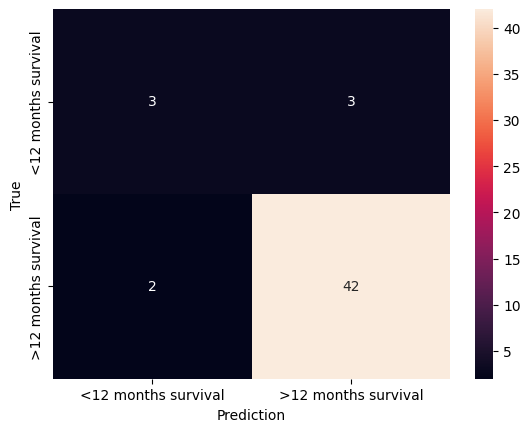

In [14]:
import seaborn as sn
import matplotlib.pyplot as plt
classe = ['<12 months survival', '>12 months survival']
sn.heatmap(confusion_matrix, annot=True, xticklabels = classe, yticklabels = classe)
plt.savefig('confusion_matrix_12months_without_3months.svg', format = 'svg', dpi=1200)

plt.show()

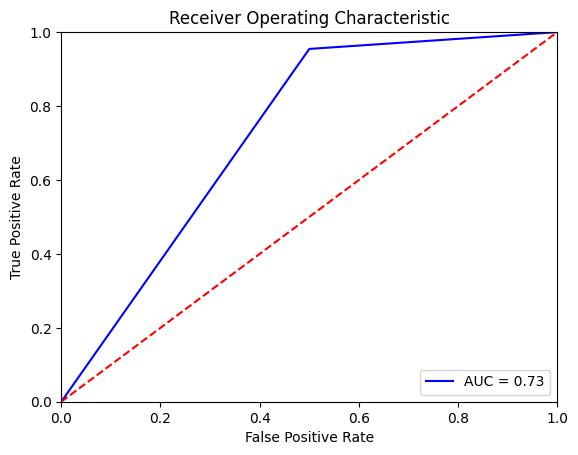

In [15]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(predictions['y_true'], predictions['y_pred'])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

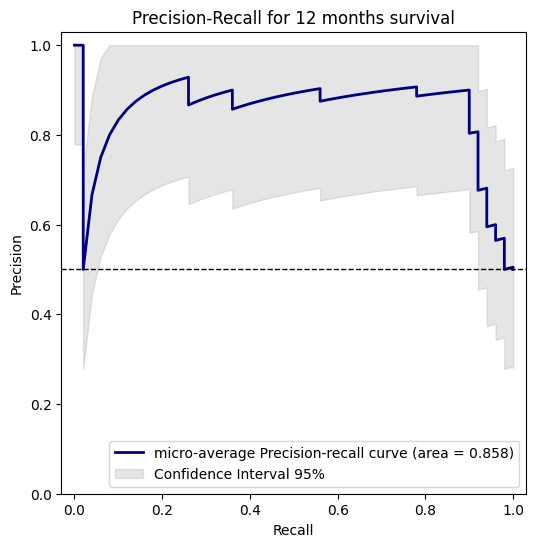

In [16]:
plot_precision_recall_curve(predictions['y_true'], predictions[['y_pred0','y_pred1']], names=['<12', '>12'], title='Precision-Recall for 12 months survival', figsize=(6,6))
plt.savefig('PR_curves_12months_without_3months.svg', format = 'svg', dpi=1200)
#plt.savefig("figures/prec_recall_Rouen.jpg",bbox_inches="tight",dpi=300)

[0.         0.02272727 0.04545455 0.16666667 0.33333333 0.38636364
 0.5        0.66666667 0.70454545 0.83333333 0.97727273 1.        ] all false positive rates
0.6885043617998163 roc_auc
[0.09469697 0.1780303  0.26136364 0.39772727 0.55681818 0.64015152
 0.81060606 0.8219697  0.90530303 0.91666667 1.         1.        ] mean tpr
[0.31602766 0.39936099 0.48269433 0.61905796 0.77814887 0.86148221
 1.         1.         1.         1.         1.         1.        ] tprs upper
mean tprs upper 0.7880643358506125
mean tprs lower 0.42477492846446746
[0.         0.         0.04003294 0.17639658 0.33548749 0.41882082
 0.58927537 0.60063901 0.68397234 0.69533597 0.77866931 0.77866931] tprs lower


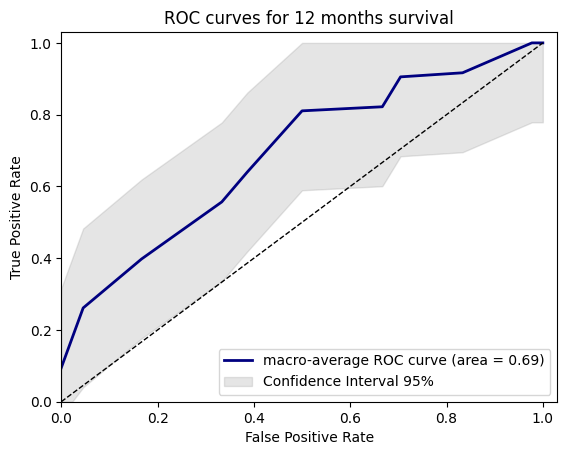

In [17]:
plot_roc_95(predictions['y_true'], predictions[['y_pred0','y_pred1']],title='ROC curves for 12 months survival')
plt.savefig('roc_curves_12months_without_3months.svg', format = 'svg', dpi=1200)

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(predictions['y_true'], predictions['y_pred']).ravel()

specificity = tn / (tn+fp)
speciality = tp / (tp+fn)
precision = tp/(tp+fp)
recall_ = tp/(tp+fn)

accuracy = accuracy_score(predictions['y_true'], predictions['y_pred'])
f1 = f1_score(predictions['y_true'], predictions['y_pred'], average='macro')
recall = recall_score(predictions['y_true'], predictions['y_pred'], average='micro')

print('accuracy', accuracy, 'f1', f1, 'recall', recall, 'specificity', specificity, 'speciality', speciality, 'precision', precision, 'recall_', recall_)

accuracy 0.9 f1 0.7446373850868233 recall 0.9 specificity 0.5 speciality 0.9545454545454546 precision 0.9333333333333333 recall_ 0.9545454545454546
